In [ ]:
# !pip install gender-guesser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 KB 6.0 MB/s eta 0:00:00


## Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import Counter
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch
import torch.nn as nn
import gender_guesser.detector as gender
import altair as alt
alt.data_transformers.disable_max_rows()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


DataTransformerRegistry.enable('default')

In [ ]:
df = pd.read_csv('poki.csv')
df

,id,title,author,grade,text,char
0,104987,I Love The Zoo,NaN,1,"roses are red, violets are blue. i love the...",62
1,67185,The scary forest.,NaN,1,the forest is really haunted. i believe it to...,87
2,103555,A Hike At School,1st grade-wh,1,i took a hike at school today and this is wha...,324
3,112483,Computer,a,1,you can do what you want you can play a...,106
4,74516,Angel,aab,1,angel oh angle you spin like a top angel oh an...,164
...,...,...,...,...,...,...
61503,116016,Arrival,zane,12,i hate when i arrive to things so late whethe...,566
61504,31414,To all the Poets,zechariah,12,your works of poetry enspire within my heart a...,440
61505,31412,The summer meadows,zechariah,12,in the summer walking through the polder i bre...,341
61506,73996,Computer,zoe,12,my computer's very neat it's got cool colours ...,66


In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['cleaned_poem'] = df['text'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)

def tokenize_text(text):
    stop_words = stopwords.words('english')
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return words

df['tokenized_poem'] = df['cleaned_poem'].apply(tokenize_text)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(words):
    return [lemmatizer.lemmatize(word) for word in words]

df['lemmatized_poem'] = df['tokenized_poem'].apply(lemmatize_text)

In [ ]:
df.head()

,id,title,author,grade,text,char,cleaned_poem,cleaned_title,tokenized_poem,lemmatized_poem
0,104987,I Love The Zoo,NaN,1,"roses are red, violets are blue. i love the...",62,roses are red violets are blue i love the z...,i love the zoo,"[roses, red, violets, blue, love, zoo]","[rose, red, violet, blue, love, zoo]"
1,67185,The scary forest.,NaN,1,the forest is really haunted. i believe it to...,87,the forest is really haunted i believe it to ...,the scary forest,"[forest, really, haunted, believe, going, camp...","[forest, really, haunted, believe, going, camp..."
2,103555,A Hike At School,1st grade-wh,1,i took a hike at school today and this is wha...,324,i took a hike at school today and this is wha...,a hike at school,"[took, hike, school, today, saw, bouncing, bal...","[took, hike, school, today, saw, bouncing, bal..."
3,112483,Computer,a,1,you can do what you want you can play a...,106,you can do what you want you can play a...,computer,"[want, play, game, many, things, read, write]","[want, play, game, many, thing, read, write]"
4,74516,Angel,aab,1,angel oh angle you spin like a top angel oh an...,164,angel oh angle you spin like a top angel oh an...,angel,"[angel, oh, angle, spin, like, top, angel, oh,...","[angel, oh, angle, spin, like, top, angel, oh,..."


## Sentiment Analysis

### Valence Aware Dictionary for Sentiment Reasoning (VADER) sentiment analysis

In [ ]:
sid = SentimentIntensityAnalyzer()

df['title_sentiment_scores'] = df['cleaned_title'].apply(lambda x: sid.polarity_scores(x))
df['title_compound_score'] = df['title_sentiment_scores'].apply(lambda x: x['compound'])
df['title_sentiment'] = df['title_compound_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
df['text_sentiment_scores'] = df['cleaned_poem'].apply(lambda x: sid.polarity_scores(x))
df['text_compound_score'] = df['text_sentiment_scores'].apply(lambda x: x['compound'])
df['text_sentiment'] = df['text_compound_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

In [ ]:
df.head()

,id,title,author,grade,text,char,cleaned_poem,cleaned_title,tokenized_poem,lemmatized_poem,title_sentiment_scores,title_compound_score,title_sentiment,text_sentiment_scores,text_compound_score,text_sentiment
0,104987,I Love The Zoo,NaN,1,"roses are red, violets are blue. i love the...",62,roses are red violets are blue i love the z...,i love the zoo,"[roses, red, violets, blue, love, zoo]","[rose, red, violet, blue, love, zoo]","{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'comp...",0.6369,positive,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.6369,positive
1,67185,The scary forest.,NaN,1,the forest is really haunted. i believe it to...,87,the forest is really haunted i believe it to ...,the scary forest,"[forest, really, haunted, believe, going, camp...","[forest, really, haunted, believe, going, camp...","{'neg': 0.615, 'neu': 0.385, 'pos': 0.0, 'comp...",-0.4939,negative,"{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp...",-0.2952,negative
2,103555,A Hike At School,1st grade-wh,1,i took a hike at school today and this is wha...,324,i took a hike at school today and this is wha...,a hike at school,"[took, hike, school, today, saw, bouncing, bal...","[took, hike, school, today, saw, bouncing, bal...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,112483,Computer,a,1,you can do what you want you can play a...,106,you can do what you want you can play a...,computer,"[want, play, game, many, things, read, write]","[want, play, game, many, thing, read, write]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'comp...",0.4019,positive
4,74516,Angel,aab,1,angel oh angle you spin like a top angel oh an...,164,angel oh angle you spin like a top angel oh an...,angel,"[angel, oh, angle, spin, like, top, angel, oh,...","[angel, oh, angle, spin, like, top, angel, oh,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.093, 'neu': 0.743, 'pos': 0.164, 'co...",0.1749,positive


In [ ]:
class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.weights = nn.Parameter(torch.randn(1))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, title_score, text_score):
        title_vector = title_score.unsqueeze(0)
        text_vector = text_score.unsqueeze(0)
        attention_weights = self.softmax(title_vector.float() * self.weights)
        context_vector = torch.matmul(attention_weights.t(), text_vector.float()).squeeze(0)
        return context_vector

weighted_score_list = []
for i in range(len(df)):
    title_score = torch.tensor(df.iloc[i].title_compound_score).float()
    text_score = torch.tensor(df.iloc[i].text_compound_score).float()
    attention_model = AttentionModel()
    weighted_score = attention_model(title_score, text_score)
    weighted_score_list.append(weighted_score.item())

### NRC Valence, Arousal, and Dominance (VAD) lexicon

https://saifmohammad.com/WebPages/nrc-vad.html

In [ ]:
def load_vad_lexicon(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    vad_lexicon = {}
    for line in lines[1:]:
        word, valence, arousal, dominance = line.strip().split('\t')
        vad_lexicon[word] = {
            'valence': float(valence),
            'arousal': float(arousal),
            'dominance': float(dominance)
        }
    return vad_lexicon

vad_lexicon_path = 'NRC-VAD-Lexicon.txt'
vad_lexicon = load_vad_lexicon(vad_lexicon_path)

In [ ]:
def compute_vad_scores(words):
    valence_sum, arousal_sum, dominance_sum, count = 0, 0, 0, 0
    for word in words:
        if word in vad_lexicon:
            count += 1
            valence_sum += vad_lexicon[word]['valence']
            arousal_sum += vad_lexicon[word]['arousal']
            dominance_sum += vad_lexicon[word]['dominance']

    if count == 0:
        return None, None, None

    return valence_sum / count, arousal_sum / count, dominance_sum / count

In [ ]:
df[['valence', 'arousal', 'dominance']] = df['lemmatized_poem'].apply(compute_vad_scores).apply(pd.Series)

In [ ]:
df.head()

,id,title,author,grade,text,char,cleaned_poem,cleaned_title,tokenized_poem,lemmatized_poem,title_sentiment_scores,title_compound_score,title_sentiment,text_sentiment_scores,text_compound_score,text_sentiment,valence,arousal,dominance
0,104987,I Love The Zoo,NaN,1,"roses are red, violets are blue. i love the...",62,roses are red violets are blue i love the z...,i love the zoo,"[roses, red, violets, blue, love, zoo]","[rose, red, violet, blue, love, zoo]","{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'comp...",0.6369,positive,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp...",0.6369,positive,0.731000,0.351500,0.451333
1,67185,The scary forest.,NaN,1,the forest is really haunted. i believe it to...,87,the forest is really haunted i believe it to ...,the scary forest,"[forest, really, haunted, believe, going, camp...","[forest, really, haunted, believe, going, camp...","{'neg': 0.615, 'neu': 0.385, 'pos': 0.0, 'comp...",-0.4939,negative,"{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp...",-0.2952,negative,0.606750,0.475000,0.529250
2,103555,A Hike At School,1st grade-wh,1,i took a hike at school today and this is wha...,324,i took a hike at school today and this is wha...,a hike at school,"[took, hike, school, today, saw, bouncing, bal...","[took, hike, school, today, saw, bouncing, bal...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.547435,0.383261,0.438609
3,112483,Computer,a,1,you can do what you want you can play a...,106,you can do what you want you can play a...,computer,"[want, play, game, many, things, read, write]","[want, play, game, many, thing, read, write]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'comp...",0.4019,positive,0.669833,0.514500,0.475667
4,74516,Angel,aab,1,angel oh angle you spin like a top angel oh an...,164,angel oh angle you spin like a top angel oh an...,angel,"[angel, oh, angle, spin, like, top, angel, oh,...","[angel, oh, angle, spin, like, top, angel, oh,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,"{'neg': 0.093, 'neu': 0.743, 'pos': 0.164, 'co...",0.1749,positive,0.644375,0.348313,0.522375


In [ ]:
df[['id','text', 'lemmatized_poem', 'valence', 'arousal', 'dominance']]

,id,text,lemmatized_poem,valence,arousal,dominance
0,104987,"roses are red, violets are blue. i love the...","[rose, red, violet, blue, love, zoo]",0.731000,0.351500,0.451333
1,67185,the forest is really haunted. i believe it to...,"[forest, really, haunted, believe, going, camp...",0.606750,0.475000,0.529250
2,103555,i took a hike at school today and this is wha...,"[took, hike, school, today, saw, bouncing, bal...",0.547435,0.383261,0.438609
3,112483,you can do what you want you can play a...,"[want, play, game, many, thing, read, write]",0.669833,0.514500,0.475667
4,74516,angel oh angle you spin like a top angel oh an...,"[angel, oh, angle, spin, like, top, angel, oh,...",0.644375,0.348313,0.522375
...,...,...,...,...,...,...
61503,116016,i hate when i arrive to things so late whethe...,"[hate, arrive, thing, late, whether, overslept...",0.524087,0.448391,0.446543
61504,31414,your works of poetry enspire within my heart a...,"[work, poetry, enspire, within, heart, deep, d...",0.575481,0.505037,0.549593
61505,31412,in the summer walking through the polder i bre...,"[summer, walking, polder, breathe, redolence, ...",0.708211,0.448368,0.590737
61506,73996,my computer's very neat it's got cool colours ...,"[computer, neat, got, cool, colour, match, seat]",0.741200,0.397000,0.569000


### NRC Word-Emotion Association Lexicon
https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [ ]:
def load_nrc_emotion_lexicon(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    emotion_lexicon = {}
    for line in lines:
        word, emotion, association = line.strip().split('\t')
        if word not in emotion_lexicon:
            emotion_lexicon[word] = {}
        emotion_lexicon[word][emotion] = int(association)
    return emotion_lexicon

nrc_emotion_lexicon_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_emotion_lexicon = load_nrc_emotion_lexicon(nrc_emotion_lexicon_path)

In [ ]:
def compute_nrc_emotion_scores(words):
    emotion_sums = {emotion: 0 for emotion in nrc_emotion_lexicon[next(iter(nrc_emotion_lexicon))].keys()}
    count = 0
    for word in words:
        if word in nrc_emotion_lexicon:
            count += 1
            for emotion, association in nrc_emotion_lexicon[word].items():
                emotion_sums[emotion] += association

    if count == 0:
        return pd.Series({emotion: None for emotion in emotion_sums.keys()})

    return pd.Series({emotion: emotion_sums[emotion] / count for emotion in emotion_sums.keys()})

In [ ]:
df = df.join(df['lemmatized_poem'].apply(compute_nrc_emotion_scores))

In [ ]:
df.head()

,id,title,author,grade,text,char,cleaned_poem,cleaned_title,tokenized_poem,lemmatized_poem,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,104987,I Love The Zoo,NaN,1,"roses are red, violets are blue. i love the...",62,roses are red violets are blue i love the z...,i love the zoo,"[roses, red, violets, blue, love, zoo]","[rose, red, violet, blue, love, zoo]",...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.166667,0.000000,0.000000
1,67185,The scary forest.,NaN,1,the forest is really haunted. i believe it to...,87,the forest is really haunted i believe it to ...,the scary forest,"[forest, really, haunted, believe, going, camp...","[forest, really, haunted, believe, going, camp...",...,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000
2,103555,A Hike At School,1st grade-wh,1,i took a hike at school today and this is wha...,324,i took a hike at school today and this is wha...,a hike at school,"[took, hike, school, today, saw, bouncing, bal...","[took, hike, school, today, saw, bouncing, bal...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.058824,0.000000,0.000000,0.117647
3,112483,Computer,a,1,you can do what you want you can play a...,106,you can do what you want you can play a...,computer,"[want, play, game, many, things, read, write]","[want, play, game, many, thing, read, write]",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,74516,Angel,aab,1,angel oh angle you spin like a top angel oh an...,164,angel oh angle you spin like a top angel oh an...,angel,"[angel, oh, angle, spin, like, top, angel, oh,...","[angel, oh, angle, spin, like, top, angel, oh,...",...,0.071429,0.428571,0.071429,0.071429,0.357143,0.071429,0.428571,0.071429,0.357143,0.428571


In [ ]:
df.columns

Index(['id', 'title', 'author', 'grade', 'text', 'char', 'cleaned_poem',
       'cleaned_title', 'tokenized_poem', 'lemmatized_poem',
       'title_sentiment_scores', 'title_compound_score', 'title_sentiment',
       'text_sentiment_scores', 'text_compound_score', 'text_sentiment',
       'valence', 'arousal', 'dominance', 'anger', 'anticipation', 'disgust',
       'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [ ]:
df[['id','lemmatized_poem', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'negative','positive']]

,id,lemmatized_poem,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,104987,"[rose, red, violet, blue, love, zoo]",0.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.166667
1,67185,"[forest, really, haunted, believe, going, camp...",0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
2,103555,"[took, hike, school, today, saw, bouncing, bal...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.058824,0.058824
3,112483,"[want, play, game, many, thing, read, write]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,74516,"[angel, oh, angle, spin, like, top, angel, oh,...",0.071429,0.428571,0.071429,0.071429,0.357143,0.071429,0.357143,0.428571,0.071429,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...
61503,116016,"[hate, arrive, thing, late, whether, overslept...",0.060606,0.151515,0.030303,0.030303,0.090909,0.151515,0.030303,0.151515,0.242424,0.181818
61504,31414,"[work, poetry, enspire, within, heart, deep, d...",0.047619,0.190476,0.000000,0.047619,0.190476,0.000000,0.095238,0.238095,0.142857,0.380952
61505,31412,"[summer, walking, polder, breathe, redolence, ...",0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.214286,0.142857,0.357143
61506,73996,"[computer, neat, got, cool, colour, match, seat]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000


## Gender Detection

In [ ]:
d = gender.Detector(case_sensitive=False)

In [ ]:
author_gender = []
for author in df['author']:
  if type(author) == float:  # if the author name is NaN
    author_gender.append('unknown')
  else:
    guess = d.get_gender(author)
    if guess == 'andy':
      author_gender.append('ambiguous')
    elif guess == 'mostly_male':
      author_gender.append('male')
    elif guess == 'mostly_female':
      author_gender.append('female')
    else:
      author_gender.append(guess)

In [ ]:
df['author_gender'] = author_gender

In [ ]:
df[['author', 'author_gender']].sample(10)

,author,author_gender
47036,ethan,male
23322,brandon,male
12885,cameron,male
40374,linse,unknown
18561,melissa,female
8286,lawrence,male
25104,dylan,male
42490,sade,female
39408,katelyn,female
18191,marissa,female


In [ ]:
df['author_gender'].value_counts()

female       28400
male         21040
unknown      11222
ambiguous      846
Name: author_gender, dtype: int64

In [ ]:
df.to_csv('scores.csv', index=False)

In [ ]:
# from google.colab import files
# files.download('scores.csv')

## Word Cloud

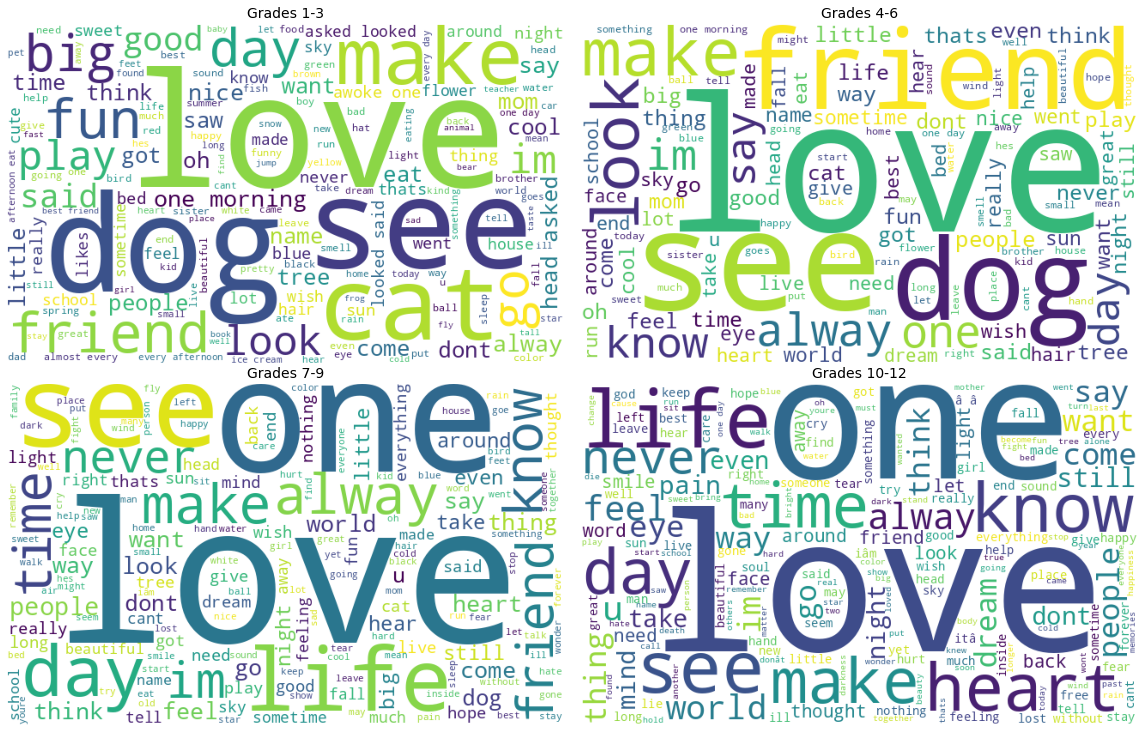

In [ ]:
grades_1_3 = df[df['grade'].isin(range(1, 4))]
grades_4_6 = df[df['grade'].isin(range(4, 7))]
grades_7_9 = df[df['grade'].isin(range(7, 10))]
grades_10_12 = df[df['grade'].isin(range(10, 13))]

def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=650, height=400, background_color='white', stopwords=None, min_font_size=10).generate(text)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(title, fontsize=14)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

generate_wordcloud(' '.join([' '.join(map(str, poem)) for poem in grades_1_3['tokenized_poem']]), 'Grades 1-3', axs[0,0])
generate_wordcloud(' '.join([' '.join(map(str, poem)) for poem in grades_4_6['tokenized_poem']]), 'Grades 4-6', axs[0,1])
generate_wordcloud(' '.join([' '.join(map(str, poem)) for poem in grades_7_9['tokenized_poem']]), 'Grades 7-9', axs[1,0])
generate_wordcloud(' '.join([' '.join(map(str, poem)) for poem in grades_10_12['tokenized_poem']]), 'Grades 10-12', axs[1,1])

plt.tight_layout(pad=0)
plt.show()

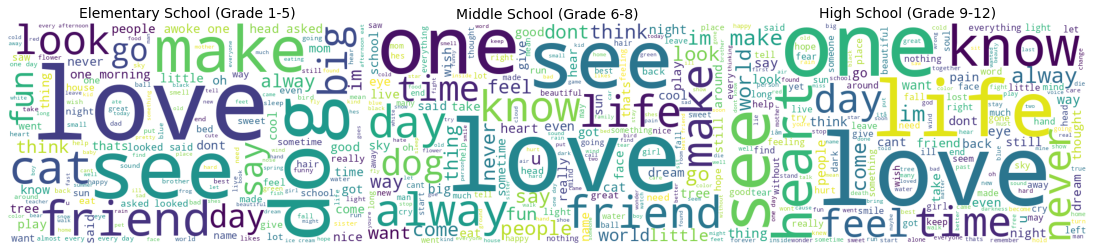

In [ ]:
elementary_school = df[df['grade'].isin(range(1, 5))]
middle_school = df[df['grade'].isin(range(6, 8))]
high_school = df[df['grade'].isin(range(9, 12))]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

generate_wordcloud(' '.join([' '.join(map(str, poem)) for poem in elementary_school['tokenized_poem']]), 'Elementary School (Grade 1-5)', axs[0])
generate_wordcloud(' '.join([' '.join(map(str, poem)) for poem in middle_school['tokenized_poem']]), 'Middle School (Grade 6-8)', axs[1])
generate_wordcloud(' '.join([' '.join(map(str, poem)) for poem in high_school['tokenized_poem']]), 'High School (Grade 9-12)', axs[2])

plt.tight_layout(pad=0)
plt.show()